# Examine and compare losses from an ensemble of models
Do this for the final epoch for an ensemble of models. In both cases, we'll assume you already ran the models and saved the checkpoints. Here we'll load in said checkpoints and examine the MSE and $\beta$-NLL losses.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scripts import train, models, analysis, io

In [4]:
# functions for loading model checkpoints
def get_best_device(fallback="cpu"):
    return torch.device("cuda:0" if torch.cuda.is_available() else fallback)

def load_model_checkpoint(model, model_name, beta, nmodel, epoch, device, path='../models'):
    """
    Load PyTorch model checkpoint from a .pt file.

    :param path: Location to load the model from
    :param DER_type: Type of your model
    :param epoch: Epoch to load
    :param device: Device to load the model onto ('cuda' or 'cpu')
    :param model: PyTorch model to load the checkpoint into
    :return: Loaded model
    """
    file_name = f"{path}/{model_name}_beta_{beta}_nmodel_{nmodel}_epoch_{epoch}.pt"
    checkpoint = torch.load(file_name, map_location=device)
    return checkpoint

def ep_al_checkpoint_DE(checkpoint):    
    # Handle the case where extra information is present in the state_dict
    '''
    if 'model_state_dict' in checkpoint:
        try:
            model.load_state_dict(checkpoint['model_state_dict'])
        except RuntimeError:
            print('cannot load via state dict')
            #print('checkpoint', checkpoint)
            #print('attempting to load', model.load_state_dict(checkpoint))
            #model.load_state_dict(checkpoint)
    else:
        model.load_state_dict(checkpoint)
    '''

    # Extract additional information
    loaded_epoch = checkpoint.get('epoch', None)
    mean_validation = checkpoint.get('valid_mean', None)
    sigma_validation = checkpoint.get('valid_sigma', None)

    
    return model, loaded_epoch, mean_validation, sigma_validation

In [5]:
# in order to load the model you need to tell it what the architecture is
DEVICE = get_best_device()
loss_type = 'bnll_loss'
model, lossFn = models.model_setup_DE(loss_type, DEVICE)

In [27]:
n_models = 100
n_epochs = 100

final_mse = {'0.0': [],
             '0.5': [],
             '1.0': [],
             'linear_decrease': [],
             'step_decrease_to_0.5': [],
             'step_decrease_to_0.0': []}
final_bnll = {'0.0': [],
              '0.5': [],
              '1.0': [],
              'linear_decrease': [],
              'step_decrease_to_0.5': [],
              'step_decrease_to_0.0': []}
model_n = {'0.0': [],
           '0.5': [],
           '1.0': [],
           'linear_decrease': [],
           'step_decrease_to_0.5': [],
           'step_decrease_to_0.0': []}

for n in range(n_models):
    #for e in range(n_epochs):
    # grab just the final checkpoint
    try:
        chk = load_model_checkpoint(model, 'DE_noise_low', 0.0, n, n_epochs-1, DEVICE)
    except FileNotFoundError:
        break
    final_mse['0.0'].append(chk['valid_mse'])
    final_bnll['0.0'].append(chk['valid_loss'])
    model_n['0.0'].append(n)
    try:
        chk = load_model_checkpoint(model, 'DE_noise_low', 0.5, n, n_epochs-1, DEVICE)
    except FileNotFoundError:
        break
    final_mse['0.5'].append(chk['valid_mse'])
    final_bnll['0.5'].append(chk['valid_loss'])
    model_n['0.5'].append(n)
    try:
        chk = load_model_checkpoint(model, 'DE_noise_low', 1.0, n, n_epochs-1, DEVICE)
    except FileNotFoundError:
        break
    final_mse['1.0'].append(chk['valid_mse'])
    final_bnll['1.0'].append(chk['valid_loss'])
    model_n['1.0'].append(n)
    try:
        chk = load_model_checkpoint(model, 'DE_noise_low', 'linear_decrease', n, n_epochs-1, DEVICE)
    except FileNotFoundError:
        break
    final_mse['linear_decrease'].append(chk['valid_mse'])
    final_bnll['linear_decrease'].append(chk['valid_loss'])
    model_n['linear_decrease'].append(n)
    try:
        chk = load_model_checkpoint(model, 'DE_noise_low', 'step_decrease_to_0.5', n, n_epochs-1, DEVICE)
    except FileNotFoundError:
        break
    final_mse['step_decrease_to_0.5'].append(chk['valid_mse'])
    final_bnll['step_decrease_to_0.5'].append(chk['valid_loss'])
    model_n['step_decrease_to_0.5'].append(n)
    try:
        chk = load_model_checkpoint(model, 'DE_noise_low', 'step_decrease_to_0.0', n, n_epochs-1, DEVICE)
    except FileNotFoundError:
        break
    final_mse['step_decrease_to_0.0'].append(chk['valid_mse'])
    final_bnll['step_decrease_to_0.0'].append(chk['valid_loss'])
    model_n['step_decrease_to_0.0'].append(n)

## Plotting for the MSE loss
This *should* be the smallest for $\beta = 1.0$ which reduces to MSE.

$\beta = 0.0$ 3.56 +/- 3.7
$\beta = 0.5$ 2.9 +/- 2.36
$\beta = 1.0$ 3.55 +/- 2.6
$\beta$ linear decrease 4.06 +/- 4.36
$\beta$ step_decrease_to_0.5 3.29 +/- 2.03
$\beta$ step_decrease_to_0.0 8.41 +/- 25.36


<Figure size 640x480 with 0 Axes>

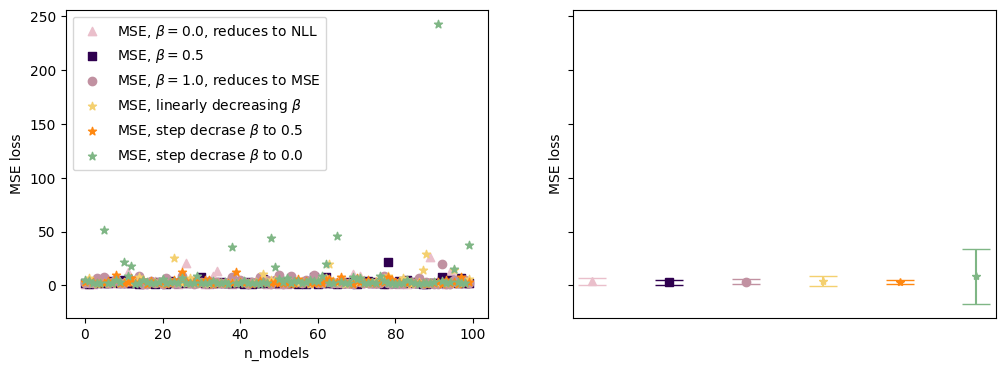

In [28]:
plt.clf()
fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize = (12,4))

ax0.scatter(model_n['0.0'],
            final_mse['0.0'],
            label = r'MSE, $\beta = 0.0$, reduces to NLL',
            color = '#EABFCB',
            marker = '^')
ax1.errorbar(1,
             np.mean(final_mse['0.0']),
             yerr = np.std(final_mse['0.0']),
             color = '#EABFCB',
             capsize = 10,
             marker = '^')
print(r'$\beta = 0.0$ '+str(round(np.mean(final_mse['0.0']),2))+' +/- '+str(round(np.std(final_mse['0.0']),2)))

ax0.scatter(model_n['0.5'],
            final_mse['0.5'],
            label = r'MSE, $\beta = 0.5$',
            color = '#2F004F',
            marker = 's')
ax1.errorbar(2,
             np.mean(final_mse['0.5']),
             yerr = np.std(final_mse['0.5']),
             color = '#2F004F',
             capsize = 10,
             marker = 's')
print(r'$\beta = 0.5$ '+str(round(np.mean(final_mse['0.5']),2))+' +/- '+str(round(np.std(final_mse['0.5']),2)))

ax0.scatter(model_n['1.0'],
            final_mse['1.0'],
            label = r'MSE, $\beta = 1.0$, reduces to MSE',
            color = '#C191A1',
            marker = 'o')
ax1.errorbar(3,
             np.mean(final_mse['1.0']),
             yerr = np.std(final_mse['1.0']),
             color = '#C191A1',
             capsize = 10,
             marker = 'o')
print(r'$\beta = 1.0$ '+str(round(np.mean(final_mse['1.0']),2))+' +/- '+str(round(np.std(final_mse['1.0']),2)))

ax0.scatter(model_n['linear_decrease'],
            final_mse['linear_decrease'],
            label = r'MSE, linearly decreasing $\beta$',
            color = '#F4D06F',
            marker = '*')
ax1.errorbar(4,
             np.mean(final_mse['linear_decrease']),
             yerr = np.std(final_mse['linear_decrease']),
             color = '#F4D06F',
             capsize = 10,
             marker = '*')
print(r'$\beta$ linear decrease '+str(round(np.mean(final_mse['linear_decrease']),2))+' +/- '+str(round(np.std(final_mse['linear_decrease']),2)))

ax0.scatter(model_n['step_decrease_to_0.5'],
            final_mse['step_decrease_to_0.5'],
            label = r'MSE, step decrase $\beta$ to 0.5',
            color = '#FF8811',
            marker = '*')
ax1.errorbar(5,
             np.mean(final_mse['step_decrease_to_0.5']),
             yerr = np.std(final_mse['step_decrease_to_0.5']),
             color = '#FF8811',
             capsize = 10,
             marker = '*')
print(r'$\beta$ step_decrease_to_0.5 '+str(round(np.mean(final_mse['step_decrease_to_0.5']),2))+' +/- '+str(round(np.std(final_mse['step_decrease_to_0.5']),2)))

ax0.scatter(model_n['step_decrease_to_0.0'],
            final_mse['step_decrease_to_0.0'],
            label = r'MSE, step decrase $\beta$ to 0.0',
            color = '#7FB685',
            marker = '*')
ax1.errorbar(6,
             np.mean(final_mse['step_decrease_to_0.0']),
             yerr = np.std(final_mse['step_decrease_to_0.0']),
             color = '#7FB685',
             capsize = 10,
             marker = '*')
print(r'$\beta$ step_decrease_to_0.0 '+str(round(np.mean(final_mse['step_decrease_to_0.0']),2))+' +/- '+str(round(np.std(final_mse['step_decrease_to_0.0']),2)))


ax0.legend()
ax0.set_xlabel('n_models')
ax0.set_ylabel('MSE loss')
ax1.set_ylabel('MSE loss')
ax1.set_xticks([])
#plt.show()
plt.savefig('MSE_different_betas.png')



## Now plotting for the NLL loss
Which is a much larger number. Recall that for the case of $\beta = 0$, the loss is trained using exactly NLL so this one should do best?

$\beta = 0.0$ 11857.62 +/- 3661.86
$\beta = 0.5$ 21145.43 +/- 13225.34
$\beta = 1.0$ 54639.84 +/- 64755.73
$\beta$ linear decrease 14197.27 +/- 5009.23
$\beta$ step_decrease_to_0.5 25327.38 +/- 14950.86
$\beta$ step_decrease_to_0.0 14524.3 +/- 5123.36


<Figure size 640x480 with 0 Axes>

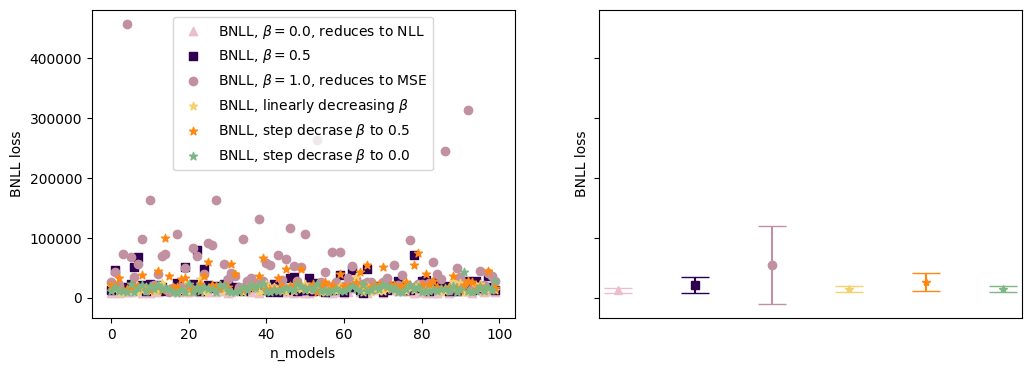

In [31]:
plt.clf()
fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize = (12,4))

ax0.scatter(model_n['0.0'],
            final_bnll['0.0'],
            label = r'BNLL, $\beta = 0.0$, reduces to NLL',
            color = '#EABFCB',
            marker = '^')
ax1.errorbar(1,
             np.mean(final_bnll['0.0']),
             yerr = np.std(final_bnll['0.0']),
             color = '#EABFCB',
             capsize = 10,
             marker = '^')
print(r'$\beta = 0.0$ '+str(round(np.mean(final_bnll['0.0']),2))+' +/- '+str(round(np.std(final_bnll['0.0']),2)))

ax0.scatter(model_n['0.5'],
            final_bnll['0.5'],
            label = r'BNLL, $\beta = 0.5$',
            color = '#2F004F',
            marker = 's')
ax1.errorbar(2,
             np.mean(final_bnll['0.5']),
             yerr = np.std(final_bnll['0.5']),
             color = '#2F004F',
             capsize = 10,
             marker = 's')
print(r'$\beta = 0.5$ '+str(round(np.mean(final_bnll['0.5']),2))+' +/- '+str(round(np.std(final_bnll['0.5']),2)))

ax0.scatter(model_n['1.0'],
            final_bnll['1.0'],
            label = r'BNLL, $\beta = 1.0$, reduces to MSE',
            color = '#C191A1',
            marker = 'o')
ax1.errorbar(3,
             np.mean(final_bnll['1.0']),
             yerr = np.std(final_bnll['1.0']),
             color = '#C191A1',
             capsize = 10,
             marker = 'o')
print(r'$\beta = 1.0$ '+str(round(np.mean(final_bnll['1.0']),2))+' +/- '+str(round(np.std(final_bnll['1.0']),2)))

ax0.scatter(model_n['linear_decrease'],
            final_bnll['linear_decrease'],
            label = r'BNLL, linearly decreasing $\beta$',
            color = '#F4D06F',
            marker = '*')
ax1.errorbar(4,
             np.mean(final_bnll['linear_decrease']),
             yerr = np.std(final_bnll['linear_decrease']),
             color = '#F4D06F',
             capsize = 10,
             marker = '*')
print(r'$\beta$ linear decrease '+str(round(np.mean(final_bnll['linear_decrease']),2))+' +/- '+str(round(np.std(final_bnll['linear_decrease']),2)))

ax0.scatter(model_n['step_decrease_to_0.5'],
            final_bnll['step_decrease_to_0.5'],
            label = r'BNLL, step decrase $\beta$ to 0.5',
            color = '#FF8811',
            marker = '*')
ax1.errorbar(5,
             np.mean(final_bnll['step_decrease_to_0.5']),
             yerr = np.std(final_bnll['step_decrease_to_0.5']),
             color = '#FF8811',
             capsize = 10,
             marker = '*')
print(r'$\beta$ step_decrease_to_0.5 '+str(round(np.mean(final_bnll['step_decrease_to_0.5']),2))+' +/- '+str(round(np.std(final_bnll['step_decrease_to_0.5']),2)))


ax0.scatter(model_n['step_decrease_to_0.0'],
            final_bnll['step_decrease_to_0.0'],
            label = r'BNLL, step decrase $\beta$ to 0.0',
            color = '#7FB685',
            marker = '*')
ax1.errorbar(6,
             np.mean(final_bnll['step_decrease_to_0.0']),
             yerr = np.std(final_bnll['step_decrease_to_0.0']),
             color = '#7FB685',
             capsize = 10,
             marker = '*')
print(r'$\beta$ step_decrease_to_0.0 '+str(round(np.mean(final_bnll['step_decrease_to_0.0']),2))+' +/- '+str(round(np.std(final_bnll['step_decrease_to_0.0']),2)))



##5F0A87
##A4508B
ax0.legend()
ax0.set_xlabel('n_models')
ax0.set_ylabel('BNLL loss')
ax1.set_ylabel('BNLL loss')
ax1.set_xticks([])
#plt.show()
plt.savefig('BNLL_different_betas.png')


In [68]:
print(max(final_mse['0.0']), final_mse['0.0'].index(max(final_mse['0.0'])))
print(max(final_bnll['0.0']), final_bnll['0.0'].index(max(final_bnll['0.0'])))

26.151079177856445 89
22284.279296875 71


In [69]:
print(max(final_mse['0.5']), final_mse['0.5'].index(max(final_mse['0.5'])))
print(max(final_bnll['0.5']), final_bnll['0.5'].index(max(final_bnll['0.5'])))

19.213037490844727 73
86294.703125 73


In [70]:
print(max(final_mse['1.0']), final_mse['1.0'].index(max(final_mse['1.0'])))
print(max(final_bnll['1.0']), final_bnll['1.0'].index(max(final_bnll['1.0'])))

19.409133911132812 92
457740.21875 4


## Lets also look at epistemic and aleatoric

In [22]:
nmodels = 100
list_mus = []
list_vars = []
for n in range(nmodels):

    model_name = 'DE_noise_low'
    #model, model_name, beta, nmodel, epoch, device, path='../models'
    chk = load_model_checkpoint(model, model_name, 'step_decrease_to_0.5', n, 99, DEVICE)
    _, _, mu_vals, var_vals = ep_al_checkpoint_DE(chk)
    list_mus.append(mu_vals.detach().numpy())
    list_vars.append(var_vals.detach().numpy())
    
ep = np.median(np.std(list_mus, axis = 0))
al_var = np.median(np.mean(list_vars, axis = 0))
print(np.shape(np.mean(list_vars, axis = 0)), np.mean(list_vars, axis = 0))
ep_std = np.std(np.std(list_mus, axis = 0))
al_var_var = np.std(np.mean(list_vars, axis = 0))
#low_ep.append(np.median(np.std(list_mus, axis = 0)))
#low_al_var.append(np.median(np.mean(list_sigs, axis = 0)))
#low_ep_std.append(np.std(np.std(list_mus, axis = 0)))
#low_al_var_std.append(np.std(np.mean(list_sigs, axis = 0)))

(10100,) [5.2326155 7.707449  2.8772192 ... 4.3972077 2.3160152 6.8339176]


In [23]:
print(ep, al_var, np.sqrt(al_var))
print(ep_std, al_var_var, np.sqrt(al_var_var))

1.1982028 4.474441 2.1152875
0.64165324 3.1942625 1.78725
